In [2]:
import torch
import torch.nn as nn
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint
import os
from PIL import Image
import glob
import time
import argparse
from math import pi
import torch.fft
from torch.utils.data import Dataset
from skimage.io import imread

##### Utils

In [3]:

path_curr_dir = os.getcwd()
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


vx, vy, vz = 88e+03, 88e+03, 250e+03 # simulated volume in nm
Nx, Ny, Nz= 512,512,50
Nx_ext, Ny_ext, Nz_ext = 2*Nx, 2*Ny, Nz
dx, dy, dz= vx/Nx, vy/Ny, vz/Nz
dn=0.2
wl = 650 #406 in nm
NA = 0.9
r = 500
nb = 1.333
k = 2*pi/wl*nb
k0 = 2*pi/wl
Rg=0.01
k = 2*pi/wl*nb
theta=0

dkx_ext = 2*pi/(Nx_ext*dx)
dky_ext = 2*pi/(Ny_ext*dy)
kx_ext = dkx_ext * (np.array([k for k in range(Nx_ext//2)] + [ k for k in range (-Nx_ext//2,0)]))
ky_ext = dky_ext * (np.array([k for k in range(Ny_ext//2)] + [ k for k in range (-Ny_ext//2,0)]))
[Kyy_ext,Kxx_ext] = np.meshgrid(ky_ext**2, kx_ext**2)

dphi_ext = np.real(k - np.sqrt((k**2 - Kxx_ext - Kyy_ext),dtype="complex64")) #diffraction phase factor extended
dphi_ext= torch.from_numpy(dphi_ext)

pupil=np.zeros((Nx_ext,Ny_ext),dtype ="complex64")
for a in range (Nx_ext):
    for b in range(Ny_ext):
        if np.sqrt(kx_ext[a]**2+ky_ext[b]**2)<= NA/wl:
            pupil[a,b]=1
        else: pupil[a,b]=0

batch_size=1
ntrain = 1
nvalid = 1
path_train = path_curr_dir + "/Training/"

batch_size_gen = 1
nvalid_batches = int(nvalid // batch_size_gen)
ntrain_batches = int(ntrain / batch_size_gen)

results_path = path_curr_dir + "/Results/"

#Np= np.int(Rg*Nx*dx*Ny*dy/(np.pi*r**2))
Np=1


max_epochs = 50

initial_learning_rate = 1

scaling_factor = 3*dn

ind_all = np.arange(0, ntrain_batches + nvalid_batches, 1)
list_all = ind_all.tolist()
list_IDs = [str(i) for i in list_all]

train_IDs = list_IDs[:ntrain_batches]
valid_IDs = list_IDs[ntrain_batches:]
partition = {'train': train_IDs, 'valid': valid_IDs}

def forwBPM(): #y en 3d pour pls éhantillons en même temps
   
    FPDist = -Nz*dz*0.5
    #pupil=setup_params['pupil_function']
    uin = torch.ones((Nx_ext,Ny_ext), dtype=torch.complex64) #à mettre sur gpu

    y = uin

    upad=torch.ones((Nx_ext,Ny_ext),dtype =torch.complex64)  #à mettre sur gpu
    for ind_z in range (Nz):
        y = torch.fft.ifftn(torch.fft.fftn(y,dim=(-2, -1))*torch.exp(-1j*dphi_ext*dz),dim=(-2, -1)) #Diffraction step
        upad[(Nx_ext-Nx)//2:(Nx_ext+Nx)//2,(Ny_ext-Ny)//2:(Ny_ext+Ny)//2] = torch.exp(1j*k0*n_zxy[ind_z]*dz)

        y=y*upad
    yvide = y
    y = torch.fft.ifftn(torch.fft.fftn(y,dim=(-2, -1))*torch.exp(-1j*dphi_ext*FPDist)*pupil,dim=(-2, -1))
    yvide= torch.fft.ifftn(torch.fft.fftn(uin,dim=(-2, -1))*torch.exp(-1j*dphi_ext*(Nz*dz+FPDist)*pupil),dim=(-2, -1))
    y=y-yvide
    y = y[(Nx_ext-Nx)//2:(Nx_ext+Nx)//2,(Ny_ext-Ny)//2:(Ny_ext+Ny)//2] #torch.narrow à check

    return y

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)


##### Generate data

In [21]:

# random seed for repeatability
torch.manual_seed(999)
np.random.seed(566)

# save the device to the settings dictionary

if not (os.path.isdir(path_train)):
    os.mkdir(path_train)
    os.mkdir(path_train+"/abs/")
    os.mkdir(path_train+"/angle/")
    os.mkdir(path_train+"/real/")
    os.mkdir(path_train+"/imag/")

# print status
print('=' * 50)
print('Sampling examples for training')
print('=' * 50)


# generate examples for training
labels_dict = {}


for i in range(ntrain_batches):

    # sample a training example
    n_zxy = np.zeros((Nz,Nx,Ny),dtype="complex")
    i_obj=randint(5,Nz-6,Np),randint(5,Nx-6,Np),randint(5,Ny-6,Np)
    z,x,y=np.array(i_obj)
    z,x,y= int(z),int(x),int(y)
    n_zxy[z-5:z+5,x-5:x+5,y-5:y+5] = dn
    n_zxy=torch.from_numpy(n_zxy)
    

    y= forwBPM()

    # save image as a tiff file and xyz to labels dict
    im_name_tiff_abs = path_train+ "/abs/" + 'im_abs_' + str(i) + '.tiff'
    img1_abs = Image.fromarray((np.abs(y.numpy())))
    img1_abs.save(im_name_tiff_abs)

    im_name_tiff_angle = path_train+ "/angle/" + 'im_angle_' + str(i) + '.tiff'
    img1_angle = Image.fromarray((np.angle(y.numpy())))
    img1_angle.save(im_name_tiff_angle)

    im_name_tiff_imag = path_train+ "/imag/" + 'im_imag_' + str(i) + '.tiff'
    img1_imag= Image.fromarray((np.imag(y.numpy())))
    img1_imag.save(im_name_tiff_imag)

    im_name_tiff_real = path_train+ "/real/" + 'im_real_' + str(i) + '.tiff'
    img1_real = Image.fromarray((np.real(y.numpy())))
    img1_real.save(im_name_tiff_real)

    labels_dict[str(i)] = i_obj
# print number of example
    print('Training Example [%d / %d]' % (i + 1, ntrain_batches))

# print status
print('=' * 50)
print('Sampling examples for validation')
print('=' * 50)

for i in range(nvalid_batches):

    n_zxy = np.zeros((Nz,Nx,Ny),dtype="complex")
    i_obj=randint(5,Nz-6,Np),randint(5,Nx-6,Np),randint(5,Ny-6,Np)
    z,x,y=np.array(i_obj)
    z,x,y= int(z),int(x),int(y)
    n_zxy[z-5:z+5,x-5:x+5,y-5:y+5] = dn
    n_zxy=torch.from_numpy(n_zxy)


    y= forwBPM()

    # save image as a tiff file and xyz to labels dict
    im_name_tiff_abs = path_train+ "/abs/" + 'im_abs_' + str(i+ntrain_batches) + '.tiff'
    img1_abs = Image.fromarray((np.abs(y.numpy())))
    img1_abs.save(im_name_tiff_abs)

    im_name_tiff_angle = path_train+ "/angle/" + 'im_angle_' + str(i+ntrain_batches) + '.tiff'
    img1_angle = Image.fromarray((np.angle(y.numpy())))
    img1_angle.save(im_name_tiff_angle)

    im_name_tiff_imag = path_train+ "/imag/" + 'im_imag_' + str(i+ntrain_batches) + '.tiff'
    img1_imag= Image.fromarray((np.imag(y.numpy())))
    img1_imag.save(im_name_tiff_imag)

    im_name_tiff_real = path_train+ "/real/" + 'im_real_' + str(i+ntrain_batches) + '.tiff'
    img1_real = Image.fromarray((np.real(y.numpy())))
    img1_real.save(im_name_tiff_real)

    labels_dict[str(i+ntrain_batches)] = i_obj
    # print number of example
    print('Validation Example [%d / %d]' % (i + 1, nvalid_batches))

# save all xyz's dictionary as a pickle file
path_labels = path_train + 'labels.pickle'
with open(path_labels, 'wb') as handle:
    pickle.dump(labels_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Finished sampling examples!')


Sampling examples for training
Training Example [1 / 1]
Sampling examples for validation
Validation Example [1 / 1]
Finished sampling examples!


##### Data Loader

In [4]:
class ImagesDataset(Dataset):
    
    # initialization of the dataset
    def __init__(self, root_dir, list_IDs, labels):
        self.root_dir = root_dir
        self.list_IDs = list_IDs
        self.labels = labels
        
        
    # total number of samples in the dataset
    def __len__(self):
        return len(self.list_IDs)
    
    # sampling one example from the data
    def __getitem__(self, index):
        
        # select sample
        ID = self.list_IDs[index]
        
        # load tiff image
        im_name_abs = self.root_dir + '/abs/'+ '/im_abs_' + ID + '.tiff'
        im_np_abs = imread(im_name_abs)
        
        im_name_angle = self.root_dir + '/angle/'+ '/im_angle_' + ID + '.tiff'
        im_np_angle = imread(im_name_angle)
        
        im_name_real = self.root_dir + '/real/'+ '/im_real_' + ID + '.tiff'
        im_np_real = imread(im_name_real)
        
        im_name_imag = self.root_dir + '/imag/'+ '/im_imag_' + ID + '.tiff'
        im_np_imag = imread(im_name_imag)
        
        im_np_abs = np.expand_dims(im_np_abs, 0)
        im_np_angle = np.expand_dims(im_np_angle, 0)
        im_np_real = np.expand_dims(im_np_real, 0)
        im_np_imag = np.expand_dims(im_np_imag, 0)
        
        im_np=np.concatenate((im_np_abs,im_np_angle,im_np_real,im_np_imag),0)
        
        im_tensor=torch.from_numpy(im_np_abs)
       
        i_obj = self.labels[ID]
        
        n_zxy = np.zeros((Nz,Nx,Ny), dtype="float32")
        z,x,y=np.array(i_obj)
        z,x,y= int(z),int(x),int(y)
          
        n_zxy[z-5:z+5,x-5:x+5,y-5:y+5] = dn
      
        n_zxy=torch.from_numpy(n_zxy)
        
        return im_tensor, n_zxy

CNN

In [5]:
# Define the basic Conv-LeakyReLU-BN
class Conv2DLeakyReLUBN(nn.Module):
    def __init__(self, input_channels, layer_width, kernel_size, padding, dilation, negative_slope):
        super(Conv2DLeakyReLUBN, self).__init__()
        self.conv = nn.Conv2d(input_channels, layer_width, kernel_size, 1, padding, dilation)
        self.lrelu = nn.LeakyReLU(negative_slope, inplace=True)
        self.bn = nn.BatchNorm2d(layer_width,track_running_stats=False)

    def forward(self, x):
        out = self.conv(x)
        out = self.lrelu(out)
        out = self.bn(out)
        return out


# Localization architecture
class LocalizationCNN(nn.Module):
    def __init__(self):
        super(LocalizationCNN, self).__init__()
        self.norm = nn.BatchNorm2d(num_features=1, affine=True)
        self.nc = 128
        self.layer1 = Conv2DLeakyReLUBN(1, self.nc, 3, 1, 1, 0.2)
        self.layer2 = Conv2DLeakyReLUBN(self.nc + 1, self.nc, 3, 1, 1, 0.2)
        self.layer3 = Conv2DLeakyReLUBN(self.nc + 1, self.nc, 3, (2, 2), (2, 2), 0.2)
        self.layer4 = Conv2DLeakyReLUBN(self.nc + 1, self.nc, 3, (4, 4), (4, 4), 0.2)
        self.layer5 = Conv2DLeakyReLUBN(self.nc + 1, self.nc, 3, 1, 1, 0.2)
        self.layer6 = Conv2DLeakyReLUBN(self.nc + 1, self.nc, 3, 1, 1, 0.2)
        self.deconv1 = Conv2DLeakyReLUBN(self.nc + 1, self.nc, 3, 1, 1, 0.2)
        self.deconv2 = Conv2DLeakyReLUBN(self.nc, self.nc, 3, 1, 1, 0.2)
        self.layer7 = Conv2DLeakyReLUBN(self.nc, Nz, 3, 1, 1, 0.2)
        self.layer8 = Conv2DLeakyReLUBN(Nz, Nz, 3, 1, 1, 0.2)
        self.layer9 = Conv2DLeakyReLUBN(Nz, Nz, 3, 1, 1, 0.2)
        self.layer10 = nn.Conv2d(Nz, Nz, kernel_size=1, dilation=1)
        self.pred = nn.Hardtanh(min_val=0.0, max_val=scaling_factor)
        #self.pred = nn.LeakyReLU()
        
    def forward(self, im):

        # extract multi-scale features
        im = self.norm(im)
        out = self.layer1(im)
        features = torch.cat((out, im), 1)
        out = self.layer2(features) + out
        features = torch.cat((out, im), 1)
        out = self.layer3(features) + out
        features = torch.cat((out, im), 1)
        out = self.layer4(features) + out
        features = torch.cat((out, im), 1)
        out = self.layer5(features) + out
        features = torch.cat((out, im), 1)
        out = self.layer6(features) + out

        # upsample by 4 in xy
        features = torch.cat((out, im), 1)
        out = interpolate(features, scale_factor=1)
        out = self.deconv1(out)
        out = interpolate(out, scale_factor=1)
        out = self.deconv2(out)

        # refine z and exact xy
        out = self.layer7(out)
        out = self.layer8(out) + out
        out = self.layer9(out) + out

        # 1x1 conv and leakyrelu for final result
        out = self.layer10(out)
        out = self.pred(out)
        return out


##### Training

Epoch 1/50
Mean training loss: 0.0871,
lr= 1
Mean validation loss: 0.1093
Mean Validation Loss Improved from inf to 0.1093, Saving Model Weights...
Epoch complete in 0h 0m 1s
Epoch 2/50
Mean training loss: 0.1086,
lr= 1
Mean validation loss: 0.0318
Mean Validation Loss Improved from 0.1093 to 0.0318, Saving Model Weights...
Mean Training Validation Gap Is -0.0768, Saving Model Weights...
Epoch complete in 0h 0m 0s
Epoch 3/50
Mean training loss: 0.0245,
lr= 1
Mean validation loss: 0.0135
Mean Validation Loss Improved from 0.0318 to 0.0135, Saving Model Weights...
Mean Training Validation Gap Is -0.0109, Saving Model Weights...
Epoch complete in 0h 0m 0s
Epoch 4/50
Mean training loss: 0.0087,
lr= 1
Mean validation loss: 0.0094
Mean Validation Loss Improved from 0.0135 to 0.0094, Saving Model Weights...
Epoch complete in 0h 0m 0s
Epoch 5/50
Mean training loss: 0.0082,
lr= 1
Mean validation loss: 0.0090
Mean Validation Loss Improved from 0.0094 to 0.0090, Saving Model Weights...
Epoch comp

<Figure size 432x288 with 0 Axes>

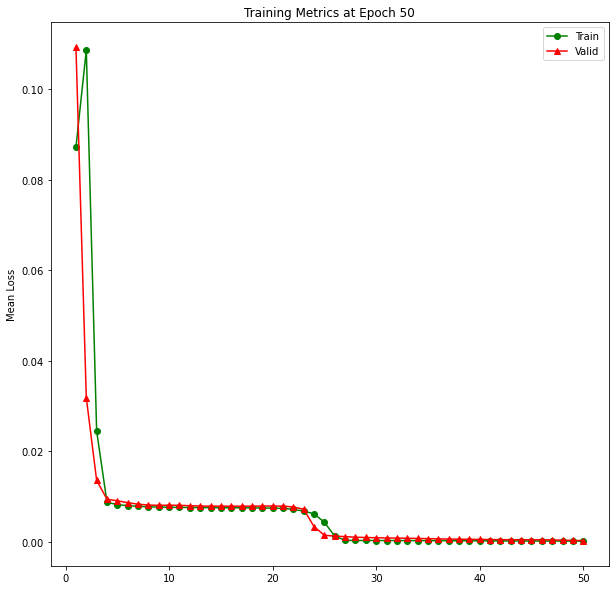

In [6]:

# set random number generators for repeatability
torch.manual_seed(999)
np.random.seed(526)
path_save= results_path
if not(os.path.isdir(path_save)):
    os.mkdir(path_save)
    
# open all locations pickle file
path_pickle = path_train + 'labels.pickle'
with open(path_pickle, 'rb') as handle:
    labels = pickle.load(handle)

# Parameters for data loaders
params_train = {'batch_size': 1, 'shuffle': True}
params_valid = {'batch_size': 1, 'shuffle': False}

# instantiate the data class and create a datalaoder for training

training_set = ImagesDataset(path_train, partition['train'], labels)
training_generator = DataLoader(training_set, **params_train)

# instantiate the data class and create a datalaoder for validation
validation_set = ImagesDataset(path_train, partition['valid'], labels)
validation_generator = training_generator
#validation_generator = DataLoader(validation_set, **params_valid)

# build model and convert all the weight tensors to cuda()

cnn = LocalizationCNN()
cnn.to(device)

# gap between validation and training loss
gap_thresh = 1e-4
steps_per_epoch = ntrain_batches/batch_size

# adam optimizer
optimizer = Adam(list(cnn.parameters()), lr=initial_learning_rate)

# learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-6)

# loss function

#criterion = KDE_loss3D(scaling_factor) 
criterion = torch.nn.MSELoss()

# start from scratch
start_epoch, end_epoch = 0, max_epochs

# initialize the learning results dictionary
learning_results = {'train_loss': [], 'valid_loss': [],
                    'max_valid': [], 'sum_valid': [], 'steps_per_epoch': steps_per_epoch}

# initialize validation set loss to be infinity
valid_loss_prev = float('Inf')

# starting time of training
train_start = time.time()

# loop over epochs
not_improve = 0
for epoch in np.arange(start_epoch, end_epoch):

    # starting time of current epoch
    epoch_start_time = time.time()

    # print current epoch number
    print('='*50)
    print('Epoch {}/{}'.format(epoch+1, end_epoch))
    print('='*50)

    # training phase
    cnn.train()
    train_loss = 0.0

    with torch.set_grad_enabled(True):
        for batch_ind, (inputs, targets) in enumerate(training_generator):

            # transfer data to variable on GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

#tau = range de criterion 
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = cnn(inputs)
            outputs = outputs.to(device)
            #print(np.unique(outputs.cpu().detach().numpy(), return_counts=True ))
            #print(np.unique(targets.cpu().detach().numpy(), return_counts=True))
            loss = criterion(outputs, targets) #+ tau*torch.nn.L1loss()(outputs, torch.zeros_like(outputs))
            #print('train loss', loss)

            loss.backward()
            optimizer.step()

            # running statistics
            train_loss += loss.item()

            # print training loss
            #print('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f\n' % (epoch+1,
                  #end_epoch, batch_ind+1, steps_per_epoch, loss.item()))

    # calculate and print mean validation loss 
    mean_train_loss = train_loss*batch_size/ntrain_batches

    print('Mean training loss: %.4f,'
          %(mean_train_loss))

    # record training loss and 
    learning_results['train_loss'].append(mean_train_loss)
    print("lr=",optimizer.param_groups[0]['lr'])
    # validation phase
    cnn.eval()
    valid_loss = 0.0

    with torch.set_grad_enabled(False):
        for batch_ind, (inputs, targets) in enumerate(validation_generator):

            # transfer data to GPU
            inputs = inputs.to(device)
            #print(np.unique(inputs.cpu(), return_counts=True))
            targets = targets.to(device)

            # forward
            optimizer.zero_grad()
            outputs = cnn(inputs)
            #print(np.unique(outputs.cpu().detach().numpy(), return_counts=True ))
            #print(np.unique(targets.cpu().detach().numpy(), return_counts=True))
            val_loss = criterion(outputs, targets)
            #print('valid loss', val_loss)
            # running statistics
            valid_loss += val_loss.item()


    # calculate and print mean validation loss 
    mean_valid_loss = valid_loss*batch_size/nvalid_batches

    print('Mean validation loss: %.4f'%mean_valid_loss)

    # record validation loss 
    learning_results['valid_loss'].append(mean_valid_loss)

    # reduce learning rate if loss stagnates
    scheduler.step(mean_valid_loss)


    # saving checkpoint: save best model so far
    if mean_valid_loss < (valid_loss_prev - 1e-4):

        # print an update and save the model weights
        print('Mean Validation Loss Improved from %.4f to %.4f, Saving Model Weights...'
              % (valid_loss_prev, mean_valid_loss))
        torch.save(cnn.state_dict(), path_save + 'weights_best_loss.pkl')

        # change minimal loss and init stagnation indicator
        valid_loss_prev = mean_valid_loss
        not_improve = 0

        # save model and current loss + optimizer
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': cnn.state_dict(),
            'best_loss': mean_valid_loss,
            'optimizer': optimizer.state_dict()}, path_save + 'checkpoint.pth.tar')
    else:
        # update stagnation indicator
        not_improve += 1
        print('No improvement in mean loss for %d epochs' % not_improve)

    # save also when training departs from validation
    train_valid_gap = mean_valid_loss - mean_train_loss
    if train_valid_gap < gap_thresh:

        # print an update and save the model weights
        print('Mean Training Validation Gap Is %.4f, Saving Model Weights...' % train_valid_gap)
        torch.save(cnn.state_dict(), path_save + 'weights_best_gap.pkl')

 
    # report time it takes the net to complete an epoch
    epoch_time_elapsed = time.time() - epoch_start_time
    print('Epoch complete in {:.0f}h {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 3600, 
            np.floor((epoch_time_elapsed / 3600 - epoch_time_elapsed // 3600)*60), 
            epoch_time_elapsed % 60))

    # save all records for latter visualization
    path_learning_results = path_save + 'learning_results.pickle'
    with open(path_learning_results, 'wb') as handle:
        pickle.dump(learning_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # if no improvement for more than 50 epochs break training
    if not_improve >= 10:
        break

# measure time that took the model to train
train_time_elapsed = time.time() - train_start
print('='*50)
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        train_time_elapsed // 3600, 
        np.floor((train_time_elapsed/3600 - train_time_elapsed // 3600)*60), 
        train_time_elapsed % 60))

# print a summary of best test loss
print('Best Validation Loss: {:4f}'.format(mean_valid_loss))

# save training time and best loss 
learning_results['epoch_converged'] = epoch
learning_results['last_epoch_time'], learning_results['training_time'] = epoch_time_elapsed, train_time_elapsed

path_learning_results = path_save + 'learning_results.pickle'
with open(path_learning_results, 'wb') as handle:
    pickle.dump(learning_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
plt.figure(1)
# x axis for the plot
steps_per_epoch = learning_results['steps_per_epoch']
iter_axis = np.arange(steps_per_epoch, steps_per_epoch * (epoch + 1) + 1, steps_per_epoch)        

# plot result
plt.clf()
plt.figure(figsize=(10,10))
linet, linev = plt.plot(iter_axis, learning_results['train_loss'], '-og', iter_axis, learning_results['valid_loss'], '-^r')
plt.ylabel("Mean Loss")
plt.legend((linet, linev), ('Train', 'Valid'))
plt.title("Training Metrics at Epoch %d" % (epoch + 1))
plt.draw()



##### Testing

In [ ]:

cnn.load_state_dict(torch.load(path_results + 'weights_best_loss.pkl'))
cnn.eval()

stock_outputs=torch.empty((nvalid,Nz,512,512), device="cuda:3")
stock_targets=torch.empty((nvalid,Nz,512,512), device="cuda:3")
stock_inputs=torch.empty((nvalid,4,512,512), device="cuda:3")

with torch.set_grad_enabled(False):
    for batch_ind, (inputs, targets) in enumerate(validation_generator):

        # transfer data to GPU
        stock_inputs[batch_ind] = inputs
        inputs = inputs.to(device)
        #print(np.unique(inputs.cpu(), return_counts=True))
       
        targets = targets.to(device)
        #print(np.unique(targets.cpu(), return_counts=True))
      
        stock_targets[batch_ind] = targets
        outputs = cnn(inputs)
        stock_outputs[batch_ind] = outputs
        
inputs = stock_inputs[0]
outputs = stock_outputs[0]
targets = stock_targets[0]


In [ ]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(8,5))
#plt.subplots_adjust(left=0.25, bottom=0.25)
fig.add_subplot(1,2,1,xticks=[], yticks=[])              
plt.imshow(inputs.cpu()[0,:,:], cmap='gray',aspect='auto')
plt.title("inputs")
fig.add_subplot(1,2,2,xticks=[], yticks=[])
plt.imshow( np.abs(pupil, cmap='gray', aspect='auto') 
plt.title("pupil")
plt.show()

In [ ]:
%matplotlib widget

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,4))
plt.subplots_adjust(left=0.25, bottom=0.25)
fig.add_subplot(1,2,1,xticks=[], yticks=[])

l1 = plt.imshow(outputs.cpu()[0,:,:], cmap='gray')
plt.title("outputs")
plt.colorbar()     

fig.add_subplot(1,2,2,xticks=[], yticks=[])
plt.clim(0,0.2)
l2 = plt.imshow(targets.cpu()[0,:,:], cmap='gray') 
plt.title("targets")
plt.colorbar()   
plt.clim(0,0.2)
axcolor = 'lightgoldenrodyellow'
axh = plt.axes([0, 0.1, 0.65, 0.03], facecolor=axcolor)
sh=Slider(axh,'z',1,Nz, valinit=1,valstep=1)

def update(new_z):
    new_z=sh.val
    
    l1.set_data(outputs.cpu()[new_z])
    l2.set_data(targets.cpu()[new_z])

    fig.canvas.draw_idle()
sh.on_changed(update)
plt.show()